In [3]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [4]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
from fpm_01 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


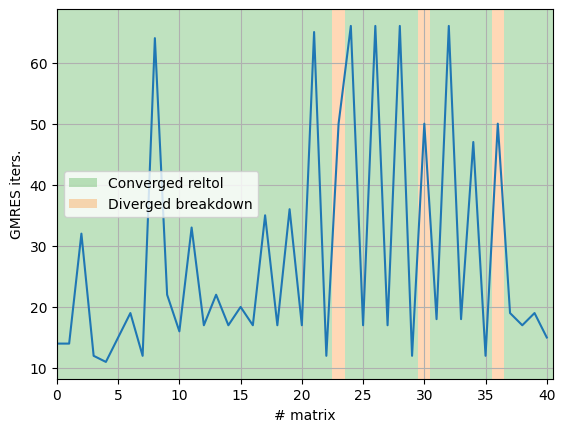

In [5]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [6]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

16

In [7]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 19
sliding = 7
open = 7
transition = 33
total = 33


In [8]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.1


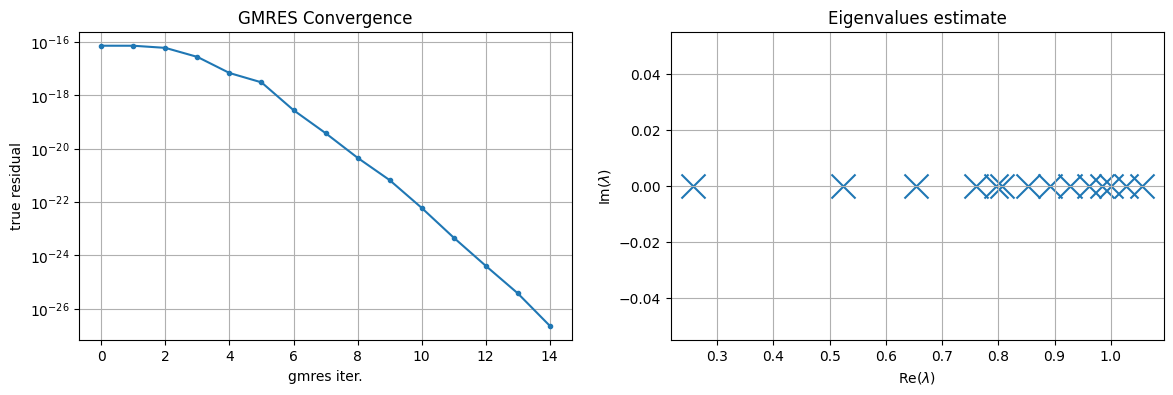

In [9]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

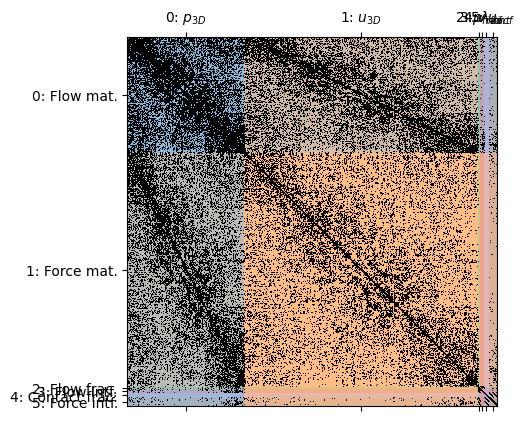

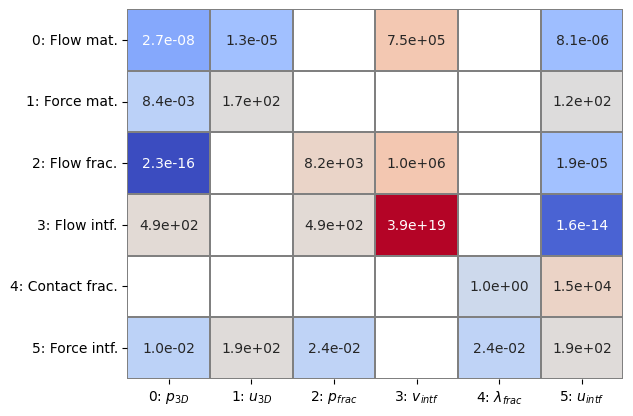

In [10]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

## Franceschini-style approach

In [19]:
def assemble_localization_matrices(bmat, keep, elim) -> list:
    # eilm: A Q1
    # keep: Q2 B


    # keep = [2]
    # elim = [1, 5]

    # keep = [5]
    # elim = [1]

    bmat = bmat[keep + elim]

    Q1 = bmat[keep, elim].mat.tocsr()
    Q2 = bmat[elim, keep].mat.tocsc()

    restrictions = []

    for frac_dof in range(Q1.shape[0]):
        restr_q1 = Q1[frac_dof, :].indices
        restr_q2 = Q2[:, frac_dof].indices
        restr = np.unique(np.concatenate([restr_q1, restr_q2]))

        col_idx = np.array(restr)
        data = np.ones_like(restr)
        row_idx = np.arange(col_idx.size)
        localization = scipy.sparse.csr_matrix(
            (data, (row_idx, col_idx)), shape=(col_idx.size, Q1.shape[1])
        )

        restrictions.append(localization)

    return restrictions
        
connectivity_list = assemble_localization_matrices(J, keep=[5], elim=[1])
connectivity_list[-1].indices

array([2476, 2477, 2628, 2629, 2714, 2715, 3320, 3321], dtype=int32)

In [78]:
connectivity_list = assemble_localization_matrices(J, keep=[2], elim=[1, 5])
connectivity_list[0].indices

array([3598, 3599, 3664, 3665], dtype=int32)

Todo:

* Elim 1 -> 5 based on local indices Q1, Q2
* Elim 5 -> 2 based on local indices Q1, Q2

In [67]:
def make_local_prec(bmat, keep, elim):
    localization_mats = assemble_localization_matrices(bmat, keep=keep, elim=elim)


    J_keep = bmat[elim].mat
    Jkeep_inv = csr_zeros(J_keep.shape[0])

    for R in localization_mats:
        j15 = R @ J_keep @ R.T
        # j15 = R @ R.T

        j15_inv = inv(j15)
        Jkeep_inv += R.T @ j15_inv @ R

    return Jkeep_inv


J11_inv = make_local_prec(J[[1, 5]], keep=[5], elim=[1])
spy(J11_inv, marker="+")

ValueError: need at least one array to concatenate

Returning only Schur complement based on [5]
Solve  took: 0.0


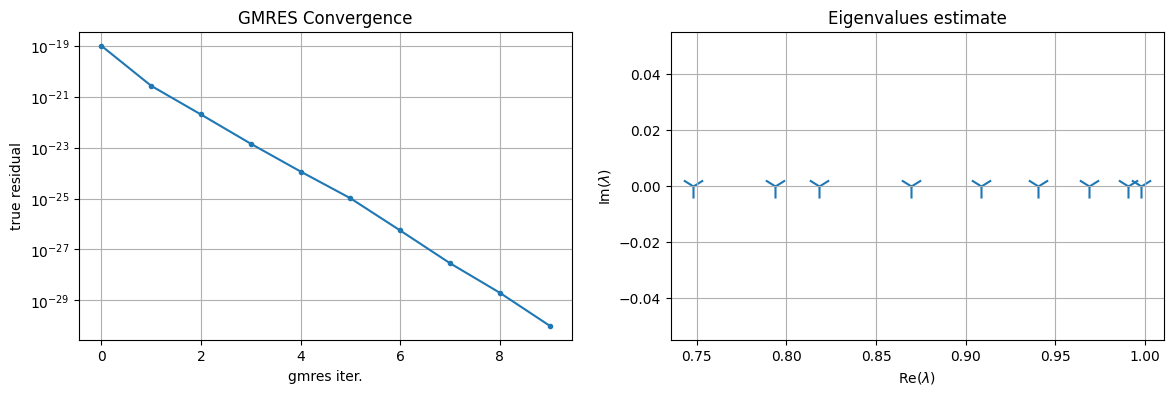

In [73]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: make_local_prec(J, keep=[5], elim=[1]),
    # invertor_type='operator',
    
    only_complement=True,
    complement=SolveSchema(
        groups=[5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

In [54]:
J11_inv_exact = inv(J[1, 1].mat)

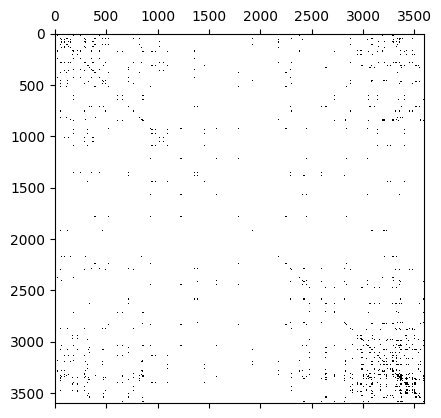

In [65]:
spy(J11_inv)

Solve  took: 0.0


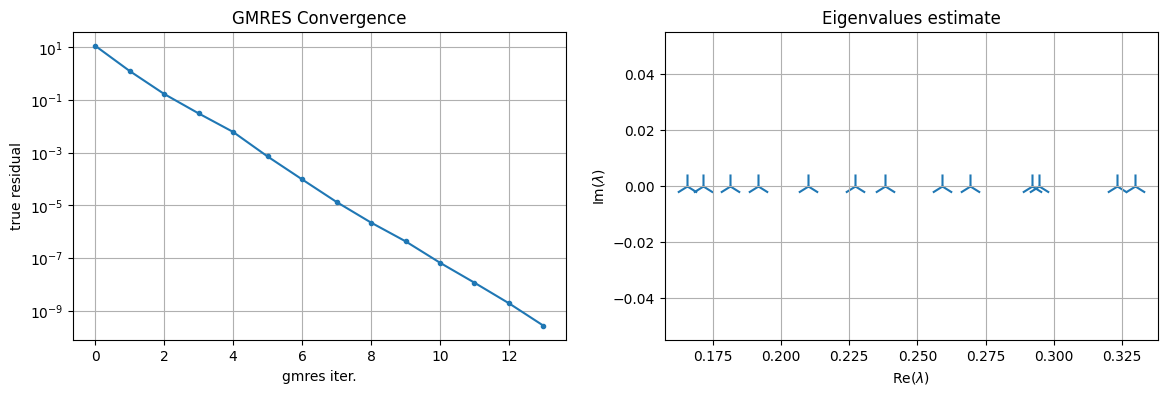

In [62]:
solve_petsc(J[5, 1].mat @ J11_inv_exact @ J[1, 5].mat, inv(J[5, 1].mat @ J11_inv @ J[1, 5].mat))

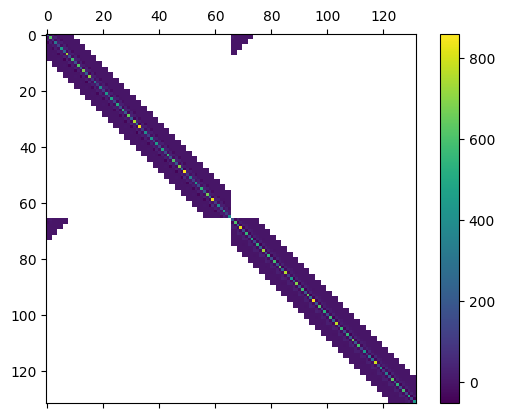

In [57]:
plot_mat(J[5, 1].mat @ J11_inv @ J[1, 5].mat, log=False)

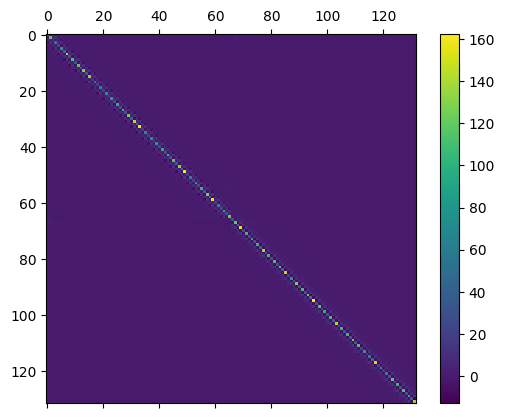

In [56]:
plot_mat(J[5, 1].mat @ J11_inv_exact @ J[1, 5].mat, log=False)

In [ ]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: S22,
    invertor_type='operator',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

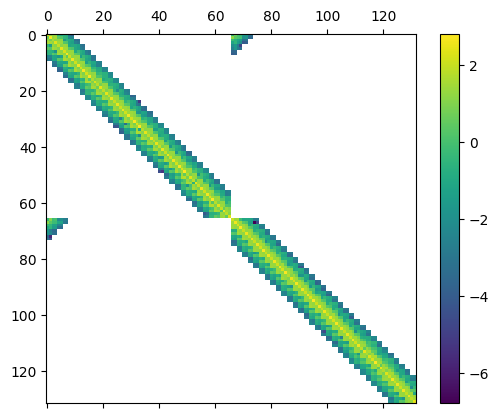

In [44]:
S55 = J[5, 5].mat - J[5, 1].mat @ J11_inv @ J[1, 5].mat
plot_mat(S55)

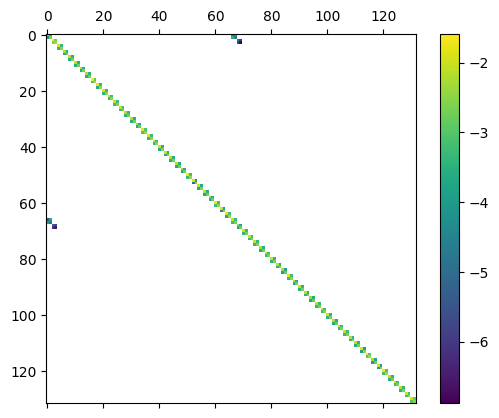

In [39]:
tmp = J.copy()
tmp[5, 5] = S55

S55_inv = make_local_prec(tmp[[2, 5]], keep=[2], elim=[5])
plot_mat(S55_inv)

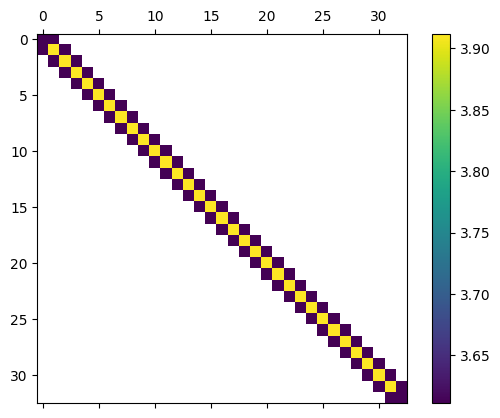

In [48]:
S22 = J[2, 2].mat - J[2, 5].mat @ S55_inv @ J[5, 2].mat

plot_mat(S22)

Solve  took: 0.25
PETSc Converged Reason: -5
lambda min: 0.25116496645153474


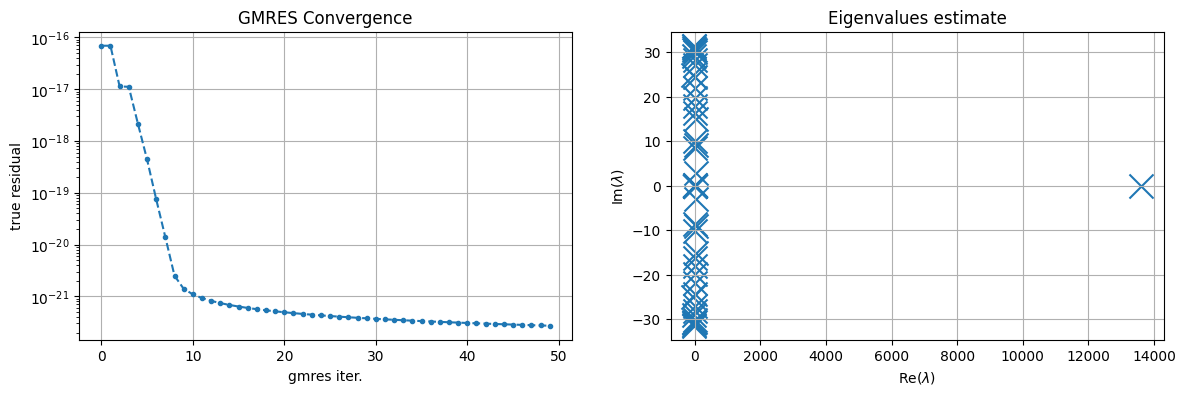

In [53]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: S22,
    invertor_type='operator',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

In [ ]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: build_prec(bmat).mat,
    invertor_type='physical',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

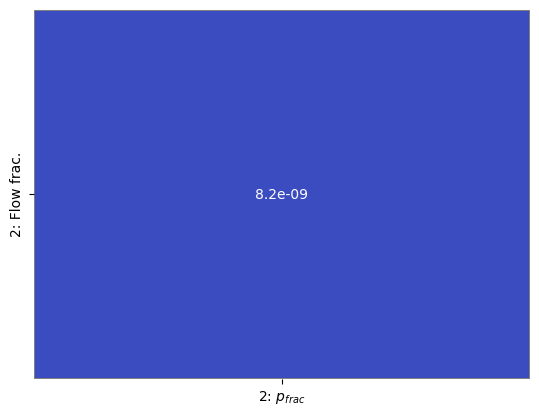

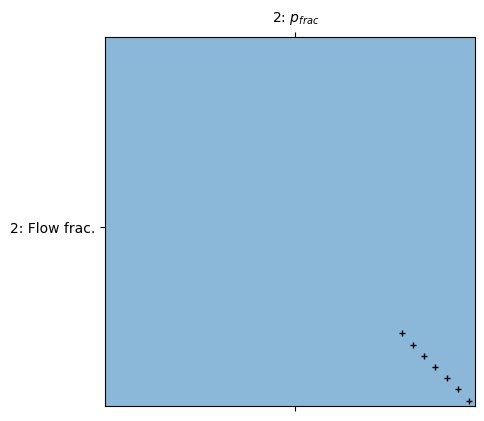

In [ ]:
def build_prec(bmat) -> BlockMatrixStorage:
    elim = [1,5]
    keep = [2]
    J15 = bmat[elim].mat
    J15_inv = csr_zeros(J15.shape[0])

    localization_mats = assemble_localization_matrices_2_15(J)

    for R in localization_mats:
        j15 = R @ J15 @ R.T
        j15_inv = inv(j15)
        J15_inv += R.T @ j15_inv @ R

    Jek = bmat[elim, keep].mat
    Jke = bmat[keep, elim].mat
    stab = bmat[keep].copy()
    stab.mat = - Jke @ J15_inv @ Jek

    # stab[0, 0] = stab[0, 0].mat + get_fixed_stress_stabilization(model)

    J2 = stab[[2], keep].mat
    not_open = np.logical_not(open_)
    assert (J2[not_open].data.size == 0), 'this matches the true inverse'
    # J2[not_open] = 0
    # stab[[2], keep] = J2
    
    # stab.mat += get_fixed_stress_stabilization_nd_new(model, J)  # This was good

    # tmp = J[[0,2]].copy()
    # tmp.mat = get_fixed_stress_stabilization_nd_new(model, J).tocsr()
    # stab[2, 2] = stab[2, 2].mat + tmp[2, 2].mat

    return stab


tmp = build_prec(J)
tmp.plot_max(); plt.show()
tmp[2, 2].color_spy()

Fails with `fpm_1_open`. Maybe because of the intersection?

Want to check with `fpm_01_open`

Solve  took: 0.0


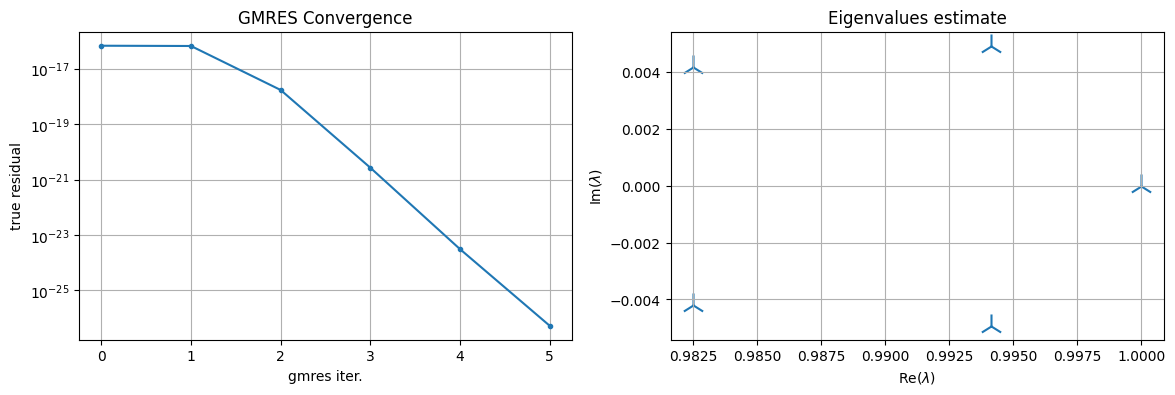

In [ ]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: build_prec(bmat).mat,
    invertor_type='physical',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Full matrix

Solve  took: 11.21
PETSc Converged Reason: -5
lambda min: 1.127751608985838


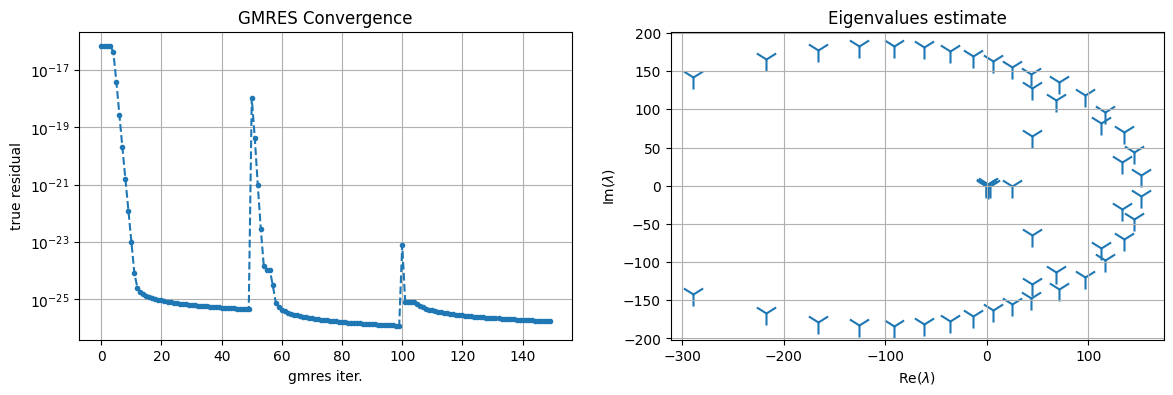

In [ ]:
from preconditioner_mech import make_J44_inv_bdiag


schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
    # only_complement=True,
    complement=SolveSchema(
        groups=[1, 5],
        # solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
        # invertor=lambda bmat: build_prec(bmat).mat,
        # invertor_type="physical",
        complement=SolveSchema(
            groups=[2],
            solve=lambda bmat: PetscAMGFlow(bmat.mat),
        ),
    ),
)


mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

In [92]:
def assemble_localization_matrices_2_15(bmat) -> list:
    # 2: A  Q1Q1Q1
    # 1: Q2 B   M1
    # 5: Q2 M2  P
    bmat = bmat[[2, 1, 5]]

    Q1 = bmat[2, [1, 5]].mat.tocsr()
    Q2 = bmat[[1, 5], 2].mat.tocsc()
    M1 = bmat[1, 5].mat.tocsc()
    M2 = bmat[5, 1].mat.tocsr()

    B_size = M1.shape[0]

    restrictions = []

    for frac_dof in range(Q1.shape[0]):
        restr_q1 = Q1[frac_dof, :].indices
        restr_q2 = Q2[:, frac_dof].indices
        restr = np.unique(np.concatenate([restr_q1, restr_q2]))

        restr_local = restr - B_size
        assert np.all(restr_local >= 0)
        restr_m1 = M1[:, restr_local].indices
        restr_m2 = M2[restr_local, :].indices

        restr_local = np.unique(np.concatenate([restr_m1, restr_m2]))
        assert len(restr_local) > 0
        assert np.all(restr_local < B_size)
        restr_total = np.concatenate([restr_local, restr])

        col_idx = np.array(restr_total)
        data = np.ones_like(restr_total)
        row_idx = np.arange(col_idx.size)
        localization = scipy.sparse.csr_matrix(
            (data, (row_idx, col_idx)), shape=(col_idx.size, Q1.shape[1])
        )

        restrictions.append(localization)

    return restrictions
        
connectivity_list = assemble_localization_matrices_2_15(J)
connectivity_list[-1].indices

array([ 282,  283,  366,  367, 1014, 1015, 1054, 1055, 2476, 2477, 2628,
       2629, 2714, 2715, 3320, 3321, 3662, 3663, 3728, 3729], dtype=int32)

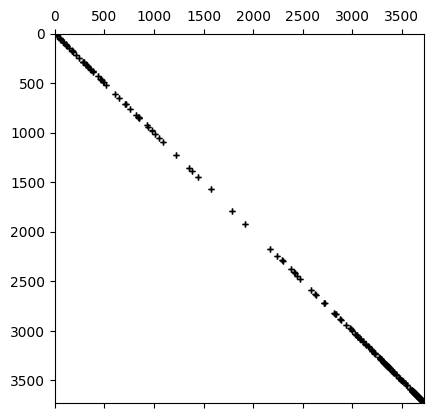

In [93]:
def make_local_prec_2_15(bmat):
    localization_mats = assemble_localization_matrices_2_15(bmat)

    J_15 = bmat[[1, 5]].mat
    J15_inv = csr_zeros(J_15.shape[0])

    for R in localization_mats:
        # j15 = R @ J_15 @ R.T
        j15 = R @ R.T

        j15_inv = inv(j15)
        J15_inv += R.T @ j15_inv @ R

    return J15_inv


J15_inv = make_local_prec_2_15(J)
spy(J15_inv, marker="+")

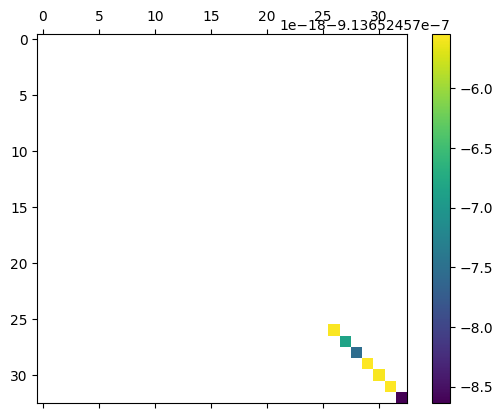

In [103]:
S22 = J[2, [1,5]].mat @ J15_inv @ J[[1, 5], 2].mat
plot_mat(S22, log=False)

Solve  took: 0.07


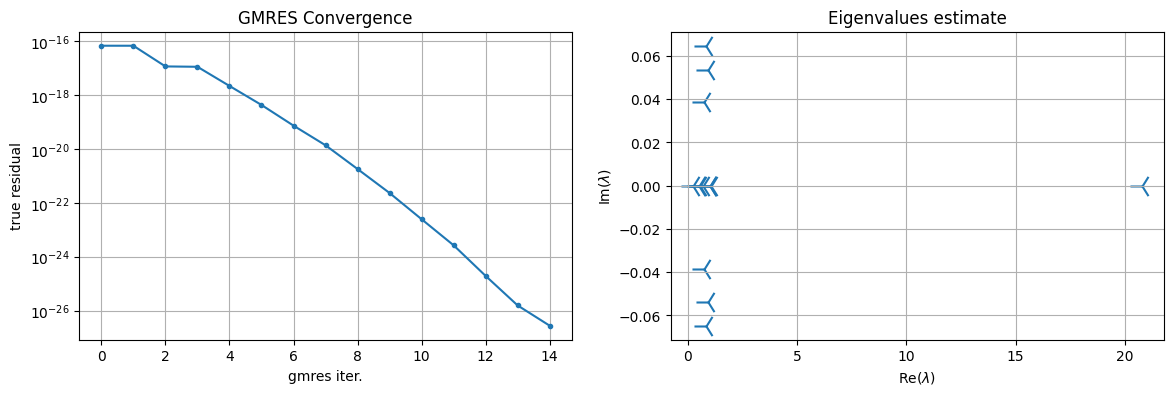

In [104]:
from block_matrix import SolveSchema, make_solver


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: make_local_prec_2_15(J),
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[2],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))